In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import warnings
warnings.simplefilter('ignore')

Необязательная фигня (нужна, если надо менять код в импортируемых модулях в процессе работы над ноутбуком).

In [2]:
%load_ext autoreload
%autoreload 2

### 1. Парсер.

Пример использования: нужна 101 форма, сохраняем архивы в заданной директории в папке 101_zipped, сами файлы сохраняются в заданной директории в папке 101. 

**Важные моменты**.
1. Поскольку эти файлы весят несколько гигабайт, я бы не рискнул загружать их в ту же папку, где хранится код для Github. Иначе, когда вы захотите закинуть свой код на гитхаб, вам придется ждать кучу времени, пока данные (больше 10 гб) передадутся.
2. Если какие-то файлы раньше были в папках, которые мы хотим стереть и которые вместе с данными создаем заново, все эти файлы надо закрыть до запуска скрипта! По умолчанию, если в папке, куда мы распаковываем данные, были подпапки с теми же названиями, что и названия папок, которые мы получим при распаковке - старые одноименные папки стираются. 
3. Сами формы 101 и 102 суммарно весят около **10 гб**. С учетом того, что они будут распакованы в два .csv файла, для скачивания и обработки форм нужно иметь не менее **15 гб** свободного места на диске.
4. **Путь**, по которому хранится файл, **должен состоять только из английских букв и слов**. Иначе некоторые Питоновские встроенные программы не работают, поскольку они не работают с кириллицей.

In [3]:
from preprocessing import load_bank_statements, get_bank_names

#### 1.1 Введем путь, по которому мы будем сохранять данные.

In [4]:
path = Path(str(input()))
print(f'Путь, по которому мы будем сохранять архивы и файлы dbf: {path}.')

D:\Users\Vladimir\Desktop\FMFI_2\bank project data
Путь, по которому мы будем сохранять архивы и файлы dbf: D:\Users\Vladimir\Desktop\FMFI_2\bank project data.


#### 1.2. Загрузим 101 и 102 формы.

In [5]:
%%time
load_bank_statements(form_number=101, filepath=path)

100%|█████████████████████████████████████| 212/212 [00:37<00:00,  5.60it/s]


Congratulations! Finished.
Wall time: 1min 3s


In [6]:
load_bank_statements(form_number=102, filepath=path)

100%|███████████████████████████████████████| 71/71 [00:04<00:00, 14.31it/s]


Congratulations! Finished.


#### 1.3. Считаем и объединим все файлы с именами.

Сделаем это для 101 и 102 формы, результат сравним. По идее, REGN - уникальные числовые индикаторы для названий банков - должны совпадать для всех форм (101, 102 и так далее) - еще один вопрос к Помориной.

Я записал путь для чтения названий банков из папки ``path/'101'``, так как такую запись позволяет библиотека Pathlib. Она есть в Питоне по умолчанию и очень удобна для работы с путями до файлов или папок.

In [7]:
out = get_bank_names(filepath=path/'101', form_number=101)

In [8]:
out.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [9]:
out102 = get_bank_names(filepath=path/'102', form_number=102)

In [10]:
out102.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [11]:
out.shape, out102.shape

((1143, 2), (1137, 2))

Не все банки, которые есть в форме 101, попали в форму 102. Возможно и обратное: если в 102 форме меньше банков, это не значит, что в ней нет названий, не попавших в форму 101. Посмотрим на банки, которые попали только в одну из двух форм:

In [12]:
mismatch = pd.concat([out, out102]).drop_duplicates(subset='REGN', keep=False)
mismatch
print(f'Количество банков, не попавших в обе формы: {mismatch.shape[0]}')

,REGN,NAME_B
712,1668,"МАБЭС ""Сахалин-Вест"" ОАО"
749,3156,КБИ БАНК ООО
834,2980,"КБ ""ЛИБРА"" ООО"
910,2220,"ЗАО ""МЕГА БАНК"""
1103,2786,ОАО Новосибирский муниципальный банк
1116,3521,"НКО ""ЮТИКПЭЙ"" (ООО)"


Количество банков, не попавших в обе формы: 6


Теперь уже за исследователем решение, что делать. Но поскольку этих банков не очень много, и они не слишком похожи на системно значимые, для модели дефолта оптимальная стратегия будет просто выкинуть их из выборки.

**Важно!** Также, чтобы не было путаницы с названиями, в дальнейшей работе надо будет использовать для работы и с формой 101, и с формой 102 один и тот же датафрейм с названиями банков - вполне возможно, название какого-то банка из формы 101 забито большими буквами в стобце `NAME_B` формы 102, может возникнуть ненужная путаница.

**Заметки по поводу агрегируемых файлов.**
1. Для сбора имен я считывал все файлы из 101 формы, в названии которых есть `N1`, для формы 102 ищутся файлы с `NP1` в названии. Но также для 2004-2008 в форме 101 есть файлы с `N`, в которых тоже содержатся имена банков - видимо, это для древнего формата отчетности. Аналогично, для формы 102 такие файлы содержат в названии `NP`. Вопрос: стоит ли учитывать более древние файлы? В связи с чем долгое время публиковались оба формата одновременно? Марина Александровна сказала разобраться с этим самостоятельно. Поскольку `N`, `NP1` в последние годы не публикуются, я решил использовать более современные файлы.
2. Аналогичный вопрос по самим отчетам - долгое время публиковалось сразу по 6 файлов за 1 месяц или квартал, то есть старый и новый форматы отчетности. В связи с чем это делалось? Стоит ли это учитывать, если да, то как? Я решил использовать более современные файлы с `B1` и `_P1` в названиях, которые публикуются с 2007 года по настоящее время.

#### 1.4. Считаем и объединим файлы с отчетностью.
Осталось считать сами файлы с отчетностью. Особенности считывания:
1. При считывании даты делаются индексом в табличке.
2. Есть ряд странных счетов в форме 101, расшифровку которых в документах ЦБ я найти не смог. Эти счета: ITGAP', '304.1', '408.1', '408.2', '474.1', '1XXXX', '2XXXX', '3XXXX', '4XXXX', '5XXXX', '6XXXX','7XXXX', '8XXXX', '9XXXX'. По умолчанию функция ``read_form`` удаляет эти счета. Это делается, чтобы столбец с номером счета можно было преобразовать в формат `integer`. Такое преобразование позволяет существенно оптимизировать скорость обработки файла и объем памяти, требуемой для хранения файла. За удаление ненужных параметров отвечает опция ``remove_unknown_accs.``
3. Опция ``to_int`` позволяет конвертировать столбец с номерами счетов в целочисленный формат.
4. До 2015 года в 102 форме не ставили столбец с датой. Это учтено, создается дата по названию папки.

In [13]:
from preprocessing import read_form

In [14]:
%%time
test = read_form(path/'101', form_number=101)

  0%|                                               | 0/177 [00:00<?, ?it/s]

Reading .dbf files from your PC, please wait...


100%|█████████████████████████████████████| 177/177 [00:48<00:00,  3.66it/s]


Opened files. Merging them...
Done.
Wall time: 2min 49s


In [17]:
test

,REGN,PLAN,NUM_SC,A_P,VR,VV,VITG,ORA,OVA,OITGA,ORP,OVP,OITGP,IR,IV,IITG,PRIZ
DT,,,,,,,,,,,,,,,,,
2007-01-01,1,А,10206,2,4540424.0,0.0,4540424.0,720888.0,0.0,720888.0,3107579.0,0.0,3107579.0,6927115.0,0.0,6927115.0,1
2007-01-01,2721,А,47411,2,6339.0,5913.0,12252.0,2935.0,726.0,3661.0,2329.0,2328.0,4657.0,5733.0,7515.0,13248.0,1
2007-01-01,2721,А,47408,1,0.0,0.0,0.0,11788.0,51990.0,63778.0,11788.0,51990.0,63778.0,0.0,0.0,0.0,1
2007-01-01,2721,А,47407,2,0.0,0.0,0.0,45580.0,18218.0,63798.0,45580.0,18218.0,63798.0,0.0,0.0,0.0,1
2007-01-01,2721,А,47405,2,0.0,0.0,0.0,0.0,4859.0,4859.0,0.0,4859.0,4859.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,1557,А,47702,2,1966.0,0.0,1966.0,44.0,0.0,44.0,57.0,0.0,57.0,1979.0,0.0,1979.0,1
2021-09-01,1557,А,47466,2,23759.0,0.0,23759.0,18274.0,0.0,18274.0,22258.0,0.0,22258.0,27743.0,0.0,27743.0,1
2021-09-01,1557,А,47462,2,0.0,0.0,0.0,263844.0,0.0,263844.0,263844.0,0.0,263844.0,0.0,0.0,0.0,1


Посмотрим на столбцы и типы данных в объединенной 101 форме.

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22335039 entries, 2007-01-01 to 2021-09-01
Data columns (total 17 columns):
 #   Column  Dtype  
---  ------  -----  
 0   REGN    int64  
 1   PLAN    object 
 2   NUM_SC  int32  
 3   A_P     object 
 4   VR      float64
 5   VV      float64
 6   VITG    float64
 7   ORA     float64
 8   OVA     float64
 9   OITGA   float64
 10  ORP     float64
 11  OVP     float64
 12  OITGP   float64
 13  IR      float64
 14  IV      float64
 15  IITG    float64
 16  PRIZ    int64  
dtypes: float64(12), int32(1), int64(2), object(2)
memory usage: 2.9+ GB


Теперь 102 форма.

In [18]:
%%time
test102 = read_form(path/'102', 102)

100%|████████████████████████████████████| 59/59 [00:00<00:00, 11794.67it/s]

Reading .dbf files from your PC, please wait...


Opened files. Merging them...
Done.
Wall time: 1min 50s


In [19]:
test102

,REGN,CODE,SIM_R,SIM_V,SIM_ITOGO
DT,,,,,
2007-01-01,1,10000,81264287.0,10621859.0,91886146.0
2007-01-01,2838,21201,0.0,0.0,0.0
2007-01-01,2838,21104,0.0,0.0,0.0
2007-01-01,2838,21103,0.0,0.0,0.0
2007-01-01,2838,21102,14.0,0.0,14.0
...,...,...,...,...,...
2021-07-01,1927,41302,0.0,0.0,0.0
2021-07-01,1927,41303,0.0,0.0,0.0
2021-07-01,1927,41400,0.0,NaN,0.0


In [20]:
test102.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28585086 entries, 2007-01-01 to 2021-07-01
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   REGN       int64  
 1   CODE       int32  
 2   SIM_R      float64
 3   SIM_V      float64
 4   SIM_ITOGO  float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.2 GB


#### 1.5 Сохраним объединенные таблицы с отчетностью.
Сохраним оба файла в папку с данными. Сохранять в ``csv`` бесполезно - это займет кучу времени. Надо сохранять в формате ``HDF``, он работает гораздо быстрее.

In [27]:
%%time
test.to_hdf(path/'101.h5', key='101', mode='w')
test102.to_hdf(path/'102.h5', key='102', mode='w')

Wall time: 33.8 s


### 2. Группировка.
Теперь попробуем работать с группировкой. 
Для группировки посчитаем 
- розничные кредиты физическим лицам, включая просроченные, 
- и кредиты юридическим лица на балансе банков по [методике КУАП](https://kuap.ru/methodics/). 

При проверке будем учитывать, что 101 форма в тысячах рублей (**Проверить что со 102 насчет размерности**).

Загрузим функцию ``group``, которая отвечает за группировку. Есть два варианта, как передать ей схему для группировки: в виде словаря или в виде датафрейма.

Предлагаю, чтобы не портить код вставками гигантских словарей для группировки по счетам, сохранять
- словари для группировки в файле parameters.py, как это сделал я со словарем для примера - ``example_dict``
- или же, если информация для группировки счетов хранится в виде датафреймов, сохранять эти датафреймы в excel или csv в папке ``data``

**Вариант 1. Словарь для группировки**.

In [5]:
form101 = pd.read_hdf(path/'101.h5',key='101')

In [14]:
from preprocessing import group
from parameters import example_dict

In [15]:
print(f"""
Первая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[0]}:{list(example_dict.values())[0][0:3]}...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[1]}:{list(example_dict.values())[1][0:3]}...
""")


Первая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты физическим лицам:[45502, 45508, 45509]...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты юридическим лицам:[45101, 45103, 45109]...



In [26]:
%%time
credits = group(data=form101, aggschema=example_dict, form=101)

Grouping and aggregating data. Please be patient...
Finished.
Wall time: 12.7 s


In [27]:
credits.head()

,REGN,new_code,IITG
DT,,,
2007-01-01,1,Кредиты физическим лицам,22332830.0
2007-01-01,1,Кредиты юридическим лицам,125305798.0
2007-02-01,1,Кредиты физическим лицам,23046669.0
2007-02-01,1,Кредиты юридическим лицам,126756486.0
2007-03-01,1,Кредиты физическим лицам,23806028.0


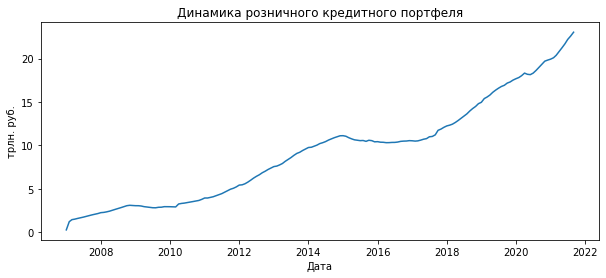

In [31]:
fiz = credits.groupby([credits.index, credits.new_code]).agg({'IITG':'sum'}).reset_index()
fiz = fiz[['DT', 'new_code', 'IITG']]
fiz.IITG = fiz.IITG/(10**9)
fiz = fiz[fiz['new_code']=='Кредиты физическим лицам']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(fiz.DT, fiz.IITG)
ax.set_title('Динамика розничного кредитного портфеля')
ax.set_xlabel('Дата')
ax.set_ylabel('трлн. руб.')
fig.show();

Что ж, здесь вполне четко видно три кредитных цикла в розничном кредитовании России. Заметим, что первое наблюдение явно похоже на выброс - в январе 2007 года банки только начали публиковать отчетность в новом формате, возможно, стоит просто выкинуть этот месяц из выборки.

Сравним с тем, что показывает ЦБ в агрегированной статистике банковского сектора за август. ЦБ показало кредиты физлицам на 23.08 трлн руб в августе, на 22.67 трлн. руб. в июле. А у нас?

In [29]:
fiz.iloc[-3:]

,DT,new_code,IITG
348,2021-07-01,Кредиты физическим лицам,22.196474
350,2021-08-01,Кредиты физическим лицам,22.583117
352,2021-09-01,Кредиты физическим лицам,23.025961


Наши расчеты стабильно меньше на 2.2%.

**Вариант 2. Датафрейм для группировки.**

Сделаем из нашего датафрейма словарь и пихнем его в функцию.

In [32]:
newdict = {y:x[0] for x in example_dict.items() for y in x[1]}
aggdf = pd.DataFrame({'new_code': newdict.values(),
                      'NUM_SC': newdict.keys()})
aggdf.head()

,new_code,NUM_SC
0,Кредиты физическим лицам,45502
1,Кредиты физическим лицам,45508
2,Кредиты физическим лицам,45509
3,Кредиты физическим лицам,45701
4,Кредиты физическим лицам,45707


In [33]:
%%time
credits_2 = group(data=form101, aggschema=aggdf, form=101)

Grouping and aggregating data. Please be patient...
Finished.
Wall time: 12.7 s


Проверим, что результаты совпадают.

In [34]:
from pandas._testing import assert_frame_equal
assert_frame_equal(credits, credits_2)

Все совпало. Это победа!